In [1]:
# Creating a notebook to simulate KOI-984 with TESS

In [2]:
# Load in the functions for computing transit:

include("../src/integrate_lightcurve.jl")
include("../test/loglinspace.jl")

logarithmspace (generic function with 1 method)

In [3]:
# Specify parameters appropriate for KOI-984.01.
# Plucking these from NexSci Kepler candidate archive.

# Radius ratio:
r = 0.025717
# Ratio of semi-major axis to stellar radius:
aonr = 19.94
# Orbital period [d]:
period = 4.28746668
# Impact parameter:
b0 = 0.374
# Transit duration [hr] (this is time between first and fourth contact):
T = 1.5693

# Check that these agree.  Compute velocity:
v = 2*pi*aonr/period
# Transit duration [convert to hr], approximate:
T0 = 2*sqrt((1+r)^2-b0^2)/v*24

println("T from NexSci: ",T," T computed: ",T0)

T from NexSci: 1.5693 T computed: 1.568868764493586


In [4]:
# Okay, now to simulate transit.  Assume a 2-minute cadence:
tobs = 3*T  # Observation duration in hours
nobs = convert(Int64,round(tobs*30))  # Number of data points
time = linearspace(-1.5*T,1.5*T,nobs)  # Time array in units of hours

-2.3539499999999998:0.03362785714285714:2.3539499999999998

In [5]:
# Okay, now compute the lightcurve.  We'll integrate a
# limb-darkened transit. Set the limb-darkening parameters:

u_n = [0.1914,0.5167]  # Quadratic limb-darkening parameters

2-element Array{Float64,1}:
 0.1914
 0.5167

In [6]:
# We'll use the function integrate_lightcurve to compute the light curve.
# First, we'll set the parameters of the transit:

trans = transit_init(r,b0,u_n,false)  # Initialize transit structure


param = [0.0,v/24,b0]   # parameters of the transit: [t_0,v,b_0]
dt = 2/60  # Transit exposure time is 2 minutes, convert to hours.

# Set up arrays to hold various parameters:
favg1 = Array{Float64,2}(undef,7,nobs)
maxdepth = 6
neval_t = Array{Int64,1}(undef,nobs)
depthmax = Array{Int64,1}(undef,nobs)
nt = nobs
tol = 1e-6
t = Array{Float64,1}(undef,nobs)
t .= time

# integrate_lightcurve!(trans::Transit_Struct{T},param::Array{T,1},t::Array{T,1},dt::T,favg1::Array{T,2},nt::Int64,tol::T,maxdepth::Int64,neval_t::Array{Int64,1},depthmax::Array{Int64,1}) where {T <: Real}
integrate_lightcurve!(trans,param,t,dt,favg1,nt,tol,maxdepth,neval_t,depthmax)



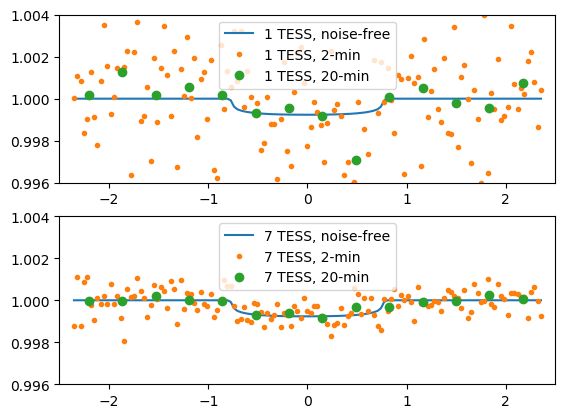

4-element Array{Float64,1}:
 -2.5  
  2.5  
  0.996
  1.004

In [7]:
# Plot noise-free light curve:
using PyPlot
using Statistics
fig,axtmp = subplots(2,1)
ax = axtmp[1]
ax[:plot](t,favg1[1,:], label="1 TESS, noise-free")

# Noise expected for TESS:
# ~$ ticgen -J 10.457 -H 10.096 -K 10.016
# TESS mag = 11.11, calculated using J/Ks.
# 1-sigma scatter in 60 min = 357 ppm.

# Add noise, scalling one hour noise up to 2 minutes: 
sigma = 3.57e-4*sqrt(60/2)
# Generate random normal noise:
noise = randn(nobs)*sigma

# Create a simulates TESS lightcurve:
f_TESS = favg1[1,:]+noise
ax[:plot](t,f_TESS,".",label="1 TESS, 2-min")

# Bin the photometry results:
tbin = zeros(14); fbin = zeros(14)
for i=1:14
    tbin[i] = mean(t[(i-1)*10+1:i*10])
    fbin[i] = mean(f_TESS[(i-1)*10+1:i*10])
end
# Plot binned points with large dots:
ax[:plot](tbin,fbin,"o",label="1 TESS, 20-min")
ax[:legend]()
ax[:axis]([-2.5,2.5,0.996,1.004])

# Now scale the noise for 7 transits (which is 
# a guesstimate for how many TESS transits will be detected):

sigma = 3.57e-4*sqrt(60/27)
noise = randn(nobs)*sigma

f_TESS = favg1[1,:]+noise
ax = axtmp[2]
ax[:plot](t,favg1[1,:], label="7 TESS, noise-free")
ax[:plot](t,f_TESS,".",label="7 TESS, 2-min")

# Bin results:
tbin = zeros(14); fbin = zeros(14)
for i=1:14
    tbin[i] = mean(t[(i-1)*10+1:i*10])
    fbin[i] = mean(f_TESS[(i-1)*10+1:i*10])
end
ax[:plot](tbin,fbin,"o",label="7 TESS, 20-min")
ax[:legend]()
ax[:axis]([-2.5,2.5,0.996,1.004])